In [73]:
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter
from scipy.integrate import simps
from scipy.stats import shapiro
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.formula.api import ols

C:\Users\Anwender\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


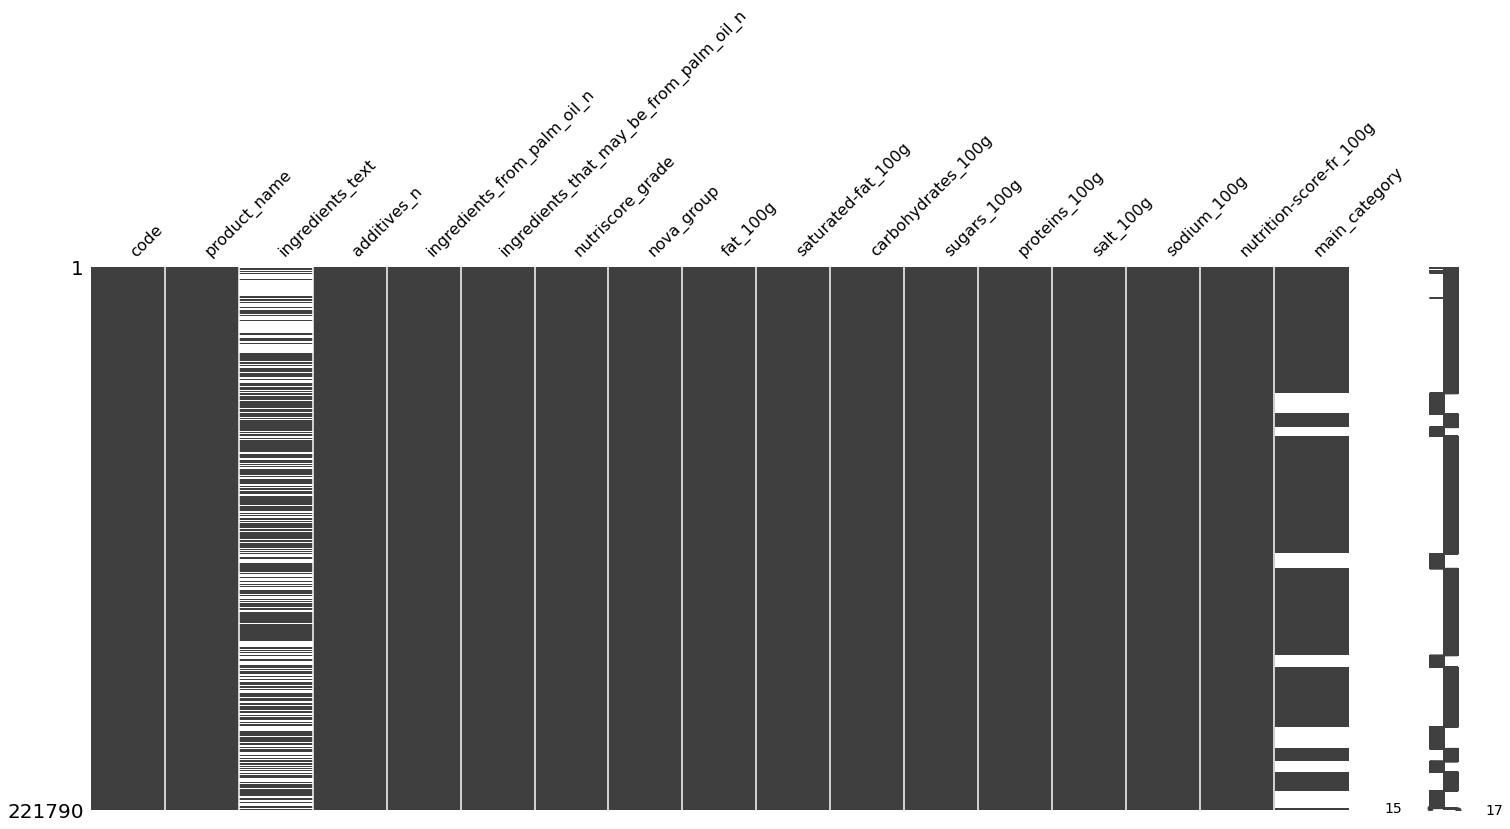

In [81]:
path_data = 'data_clean_fill'
data_fr_clean_fill = pd.read_csv(path_data)
data_fr_clean_fill.name = "data_fr_clean_fill"
data_fr_clean_fill = data_fr_clean_fill.iloc[:,1:]
msno.matrix(data_fr_clean_fill)

In [3]:
data_fr_clean_fill.iloc[0:5,:]

,code,product_name,ingredients_text,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_grade,nova_group,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,main_category
0,0000000000100,moutarde au moût de raisin,eau graines de téguments de moutarde vinaigre ...,-0.935141,-0.19656,-0.274528,d,3,-0.385157,-0.429202,0.197068,0.542349,-0.410480,1.455267,0.988786,18.0,en:mustards
1,0000000000949,Salade de carottes râpées,NaN,0.149356,-0.19656,-0.274528,b,4,-0.808006,-0.663402,-0.718980,-0.485518,-0.967340,-0.318938,-0.163201,1.0,en:seasoned-shredded-carrots
2,0000000001281,Tarte noix de coco,NaN,0.149356,-0.19656,-0.274528,d,4,0.354828,1.093098,0.120730,0.488251,-0.521852,-0.318938,-0.163201,14.0,en:coconut-pies
3,0000000001885,Compote de poire,NaN,0.149356,-0.19656,-0.274528,a,1,-0.808006,-0.663402,0.464248,0.812841,-0.967340,-0.318938,-0.163201,-2.0,en:pear-compotes
4,0000000002257,Salade de macedoine de légumes,NaN,0.149356,-0.19656,-0.274528,b,1,-0.173733,-0.546302,-0.795317,-0.593715,-0.855968,-0.318938,-0.163201,1.0,en:prepared-vegetables-macedoines


### Faisons un petit rappel de forme/statistique du dataset à la fin du nnettoyage/remplissage

In [83]:
def petit_resume_svp(d):
    df_store= pd.DataFrame(index=d.columns)
    df_store = df_store.drop(['code', 'product_name', 'main_category', 'ingredients_text', 'nutriscore_grade'])
    df_store["mean"] = d[df_store.index].mean()
    df_store["median"] = d[df_store.index].median()
    df_store["var"] = d[df_store.index].var(ddof=0)
    df_store["std"] = d[df_store.index].std(ddof=0)
    df_store["skew"] = d[df_store.index].skew()
    df_store["kurtosis"] = d[df_store.index].kurtosis()
    return(df_store)

j = petit_resume_svp(data_fr_clean_fill)
j

,mean,median,var,std,skew,kurtosis
additives_n,0.000006,0.149356,0.999982,0.999991,2.711129,13.058788
ingredients_from_palm_oil_n,0.000063,-0.196560,1.000298,1.000149,5.003355,24.179232
ingredients_that_may_be_from_palm_oil_n,-0.000019,-0.274528,0.999907,0.999953,4.470036,24.461717
nova_group,3.383728,4.000000,0.984828,0.992385,-1.559372,1.139266
fat_100g,-0.000005,-0.332301,0.999970,0.999985,2.059962,5.283390
saturated-fat_100g,-0.000018,-0.429202,0.999926,0.999963,3.082676,17.413051
carbohydrates_100g,0.000020,-0.451799,1.000008,1.000004,0.881388,-0.554394
sugars_100g,0.000022,-0.485518,0.999997,0.999999,1.899730,3.177590
proteins_100g,-0.000039,-0.299108,0.999964,0.999982,1.747514,6.299574
salt_100g,-0.000029,-0.318938,0.999876,0.999938,18.467113,583.054141


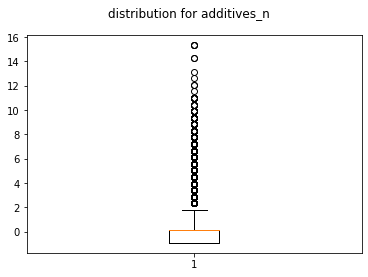

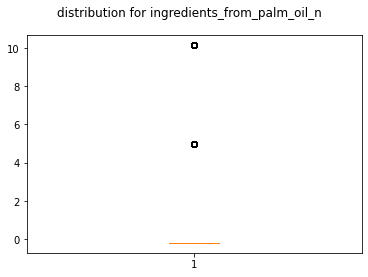

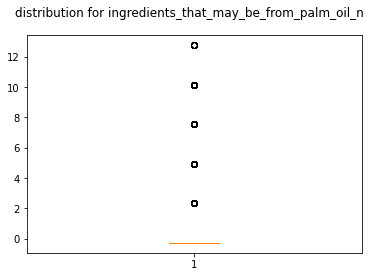

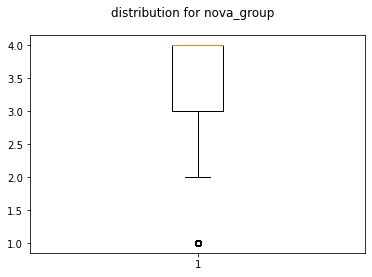

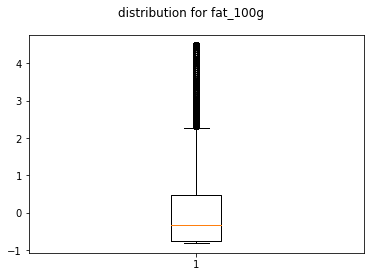

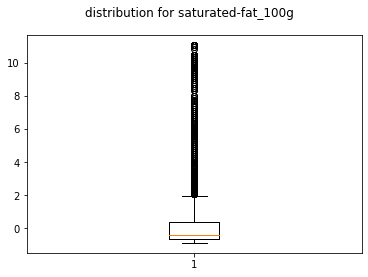

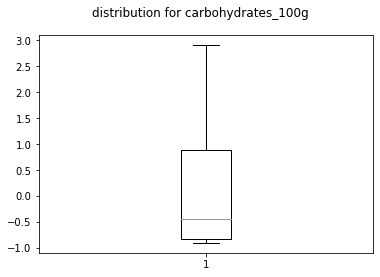

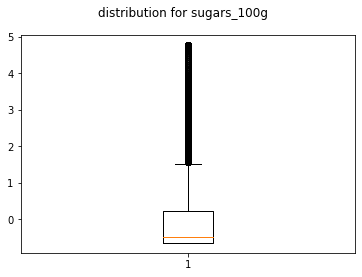

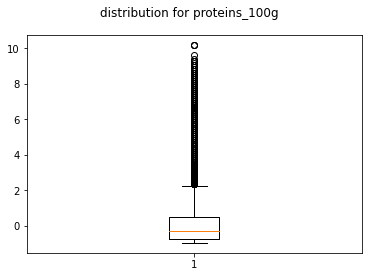

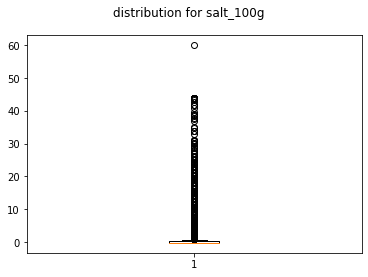

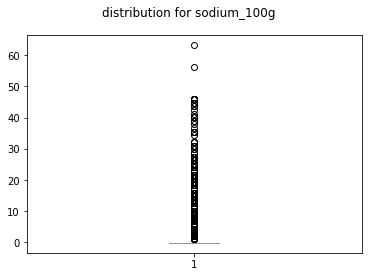

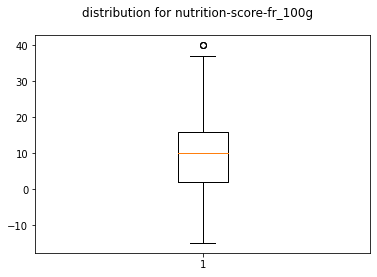

In [90]:
df_store = data_fr_clean_fill
df_store = df_store.drop(columns=['code', 'product_name', 'main_category', 'ingredients_text', 'nutriscore_grade'])
for i in df_store.columns:
    fig, (ax1) = plt.subplots(1, 1)
    fig.suptitle('distribution for '+i)
    ax1.boxplot(df_store[i])

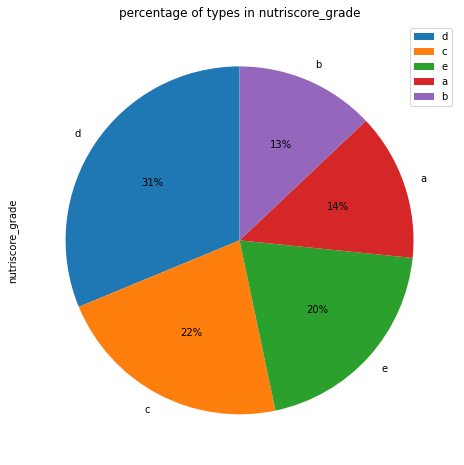

In [92]:
plt.figure(figsize=(8,8))
plt.title("percentage of types in nutriscore_grade")
data_fr_clean_fill['nutriscore_grade'].value_counts().plot.pie(autopct='%1.0f%%', startangle=90)
plt.legend(loc = "best")

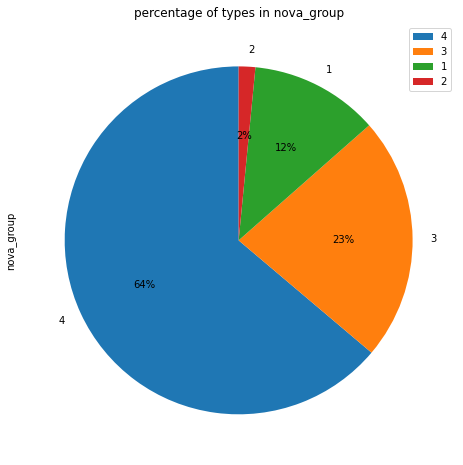

In [93]:
plt.figure(figsize=(8,8))
plt.title("percentage of types in nova_group")
data_fr_clean_fill['nova_group'].value_counts().plot.pie(autopct='%1.0f%%', startangle=90)
plt.legend(loc = "best")

In [4]:
data_fr_clean_fill.columns

Index(['code', 'product_name', 'ingredients_text', 'additives_n',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_grade',
       'nova_group', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'nutrition-score-fr_100g', 'main_category'],
      dtype='object')

In [5]:
l = ['additives_n','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n',
     'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g','sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
data_fr_clean_fill[l] = StandardScaler().fit_transform(data_fr_clean_fill[l])

In [6]:
def petit_resume_svp(d):
    df_store= pd.DataFrame(index=d.columns)
    df_store = df_store.drop(['code', 'product_name', 'main_category', 'ingredients_text', 'nutriscore_grade'])
    df_store["mean"] = round(d[df_store.index].mean(),3)
    df_store["median"] = round(d[df_store.index].median(),3)
    df_store["var"] = round(d[df_store.index].var(ddof=0),3)
    df_store["std"] = round(d[df_store.index].std(ddof=0),3)
    df_store["skew"] = round(d[df_store.index].skew(),3)
    df_store["kurtosis"] = round(d[df_store.index].kurtosis(),3)
    return(df_store)

k = petit_resume_svp(data_fr_clean_fill)
k

,mean,median,var,std,skew,kurtosis
additives_n,-0.000,0.149,1.000,1.000,2.711,13.059
ingredients_from_palm_oil_n,0.000,-0.197,1.000,1.000,5.003,24.179
ingredients_that_may_be_from_palm_oil_n,0.000,-0.275,1.000,1.000,4.470,24.462
nova_group,3.384,4.000,0.985,0.992,-1.559,1.139
fat_100g,-0.000,-0.332,1.000,1.000,2.060,5.283
saturated-fat_100g,-0.000,-0.429,1.000,1.000,3.083,17.413
carbohydrates_100g,0.000,-0.452,1.000,1.000,0.881,-0.554
sugars_100g,-0.000,-0.486,1.000,1.000,1.900,3.178
proteins_100g,0.000,-0.299,1.000,1.000,1.748,6.300
salt_100g,0.000,-0.319,1.000,1.000,18.467,583.054


In [7]:
data_fr_clean_fill.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
count,2.217900e+05,2.217900e+05,2.217900e+05,221790.000000,2.217900e+05,2.217900e+05,2.217900e+05,2.217900e+05,2.217900e+05,2.217900e+05,2.217900e+05,221790.000000
mean,-8.685324e-15,2.787419e-14,1.086548e-15,3.383728,-2.593141e-14,-2.979682e-15,5.860083e-14,-1.444134e-14,2.942721e-15,9.764564e-15,1.648633e-14,9.486072
std,1.000002e+00,1.000002e+00,1.000002e+00,0.992387,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,8.755222
min,-9.351557e-01,-1.965938e-01,-2.745218e-01,1.000000,-8.080127e-01,-8.976178e-01,-9.098398e-01,-6.478356e-01,-9.673178e-01,-3.189290e-01,-1.631970e-01,-15.000000
25%,-9.351557e-01,-1.965938e-01,-2.745218e-01,3.000000,-7.551558e-01,-6.634091e-01,-8.335029e-01,-6.478356e-01,-7.445699e-01,-3.189290e-01,-1.631970e-01,2.000000
50%,1.493514e-01,-1.965938e-01,-2.745218e-01,4.000000,-3.323009e-01,-4.292004e-01,-4.518179e-01,-4.855405e-01,-2.990741e-01,-3.189290e-01,-1.631970e-01,10.000000
75%,1.493514e-01,-1.965938e-01,-2.745218e-01,4.000000,4.605520e-01,3.905300e-01,8.840793e-01,2.177381e-01,4.805435e-01,1.246496e-01,-1.631970e-01,16.000000
max,1.533245e+01,1.014188e+01,1.274871e+01,4.000000,4.477674e+00,1.104703e+01,2.907009e+00,4.762000e+00,1.017008e+01,6.000777e+01,6.320019e+01,40.000000


## Passons à la phase exploratoire et commençons avec le PCA
pour le pca nous allons devoir standardiser les données

In [74]:
l = ['additives_n','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n',
     'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g','sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
# pca = PCA(n_components=2)
# test_sa_don = data_fr_20_fill[data_fr_20_fill.columns.intersection(l)]
test_sa_don = data_fr_clean_fill[l]
# principalComponents = pca.fit_transform(test_sa_don)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [78]:
pca = PCA()
pca.fit_transform(test_sa_don)

array([[ 0.60274718,  1.6674978 , -0.27179704, ...,  0.10093467,
        -0.21726793, -0.40510195],
       [-0.18903691,  0.03982605, -1.22537801, ...,  0.28489812,
         0.04158331,  0.08296183],
       [-0.34246757, -0.56393519,  0.73423546, ...,  0.50778225,
         0.21252853,  0.0830801 ],
       ...,
       [-1.16386784,  0.60067218, -0.78126917, ..., -1.04423931,
         1.62202716,  0.13687527],
       [-0.02610434, -0.08125774,  0.05911483, ..., -0.28591789,
         0.19563698, -0.19706778],
       [ 0.99766524, -0.56217975, -1.13569625, ...,  0.22307674,
        -0.25235992,  0.17593811]])

In [10]:
##### pca.components_ 
pca.explained_variance_

array([2.33895921, 1.84209865, 1.69468189, 1.24434564, 0.88132027,
       0.78905285, 0.61085996, 0.30572836, 0.2571565 , 0.03584176])

In [11]:
pca.explained_variance_ratio_

array([0.23389487, 0.18420903, 0.16946742, 0.124434  , 0.08813163,
       0.07890493, 0.06108572, 0.0305727 , 0.02571553, 0.00358416])

In [12]:
pca.explained_variance_ratio_.cumsum()

array([0.23389487, 0.4181039 , 0.58757133, 0.71200533, 0.80013696,
       0.87904189, 0.94012761, 0.97070031, 0.99641584, 1.        ])

In [13]:
pca.n_components_

10

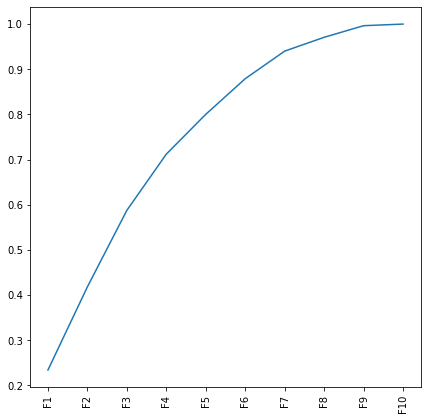

In [98]:
list_f = []
for i in range(0, test_sa_don.columns.size):
    list_f.append("F"+str(i+1))
    

plt.figure(figsize=(7,7))
plt.xticks(rotation='90')
# plt.plot(test_sa_don.columns, pca.explained_variance_ratio_.cumsum())
plt.plot(list_f, pca.explained_variance_ratio_.cumsum())

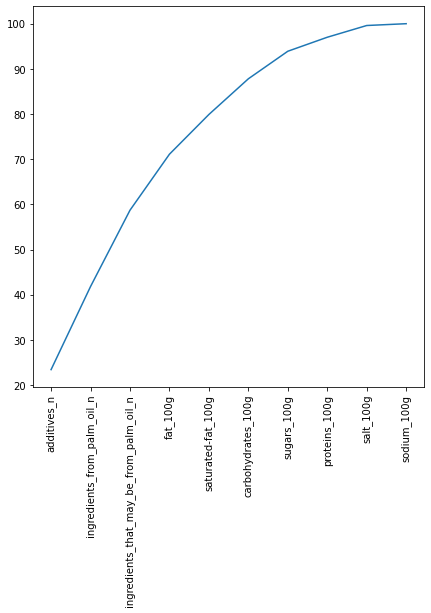

In [15]:
var = pca.explained_variance_ratio_
var=np.cumsum(np.round(var, decimals=3)*100)
plt.figure(figsize=(7,7))
plt.xticks(rotation='90')
plt.plot(test_sa_don.columns, var)

#### Remarque: pour atteindre le seuil des 80% d'information, on peut ne conserver que les 5premières composantes.

In [75]:
pca = PCA(n_components=2)
# test_sa_don = data_fr_20_fill[data_fr_20_fill.columns.intersection(l)]
test_sa_don = data_fr_clean_fill[l]

In [79]:
data_fr_clean_fill_pca = data_fr_clean_fill
data_fr_clean_fill_pca = data_fr_clean_fill_pca.drop(columns=["proteins_100g", "salt_100g", "sodium_100g"])

### Traçons le cercle de corrélation afin de pouvoir identifier des informations.

[[-1.07116103e-01  6.38755378e-02  1.04925746e-01  1.98653678e-01
  -4.72864020e-02 -1.17667404e-02  1.77520955e-01 -1.95133050e-03
   8.94842658e-03  1.22311689e-03]
 [-7.89641369e-02  2.89604110e-02  1.35201442e-01  5.16674834e-02
   2.44115414e-01 -1.06225842e-01 -3.23387050e-02  3.45878897e-03
  -8.64520538e-03 -2.36544541e-04]
 [-9.45629107e-02  3.93772580e-02  1.21375383e-01  1.93597861e-01
  -6.83195105e-02  8.57840412e-02 -1.58135290e-01  6.76853778e-03
  -1.44497223e-02 -4.64862284e-05]
 [ 9.67558787e-02 -1.43216870e-01  2.21669087e-01 -5.35676402e-02
  -5.14278597e-02 -3.02709126e-02  7.62862612e-03 -1.07168682e-01
  -5.49048568e-02  7.14628201e-04]
 [ 7.74658723e-02 -1.38226590e-01  2.34015210e-01 -6.93788295e-02
  -2.96447505e-02  9.49602363e-03  5.87185057e-03  9.79517983e-02
   6.86471612e-02  2.83890064e-04]
 [-2.22891734e-01  1.03025569e-01  6.77347833e-02 -1.15471689e-01
   2.09487434e-02  8.80314073e-02 -2.28575123e-03 -7.64797346e-02
   8.79957346e-02  3.21540136e-04

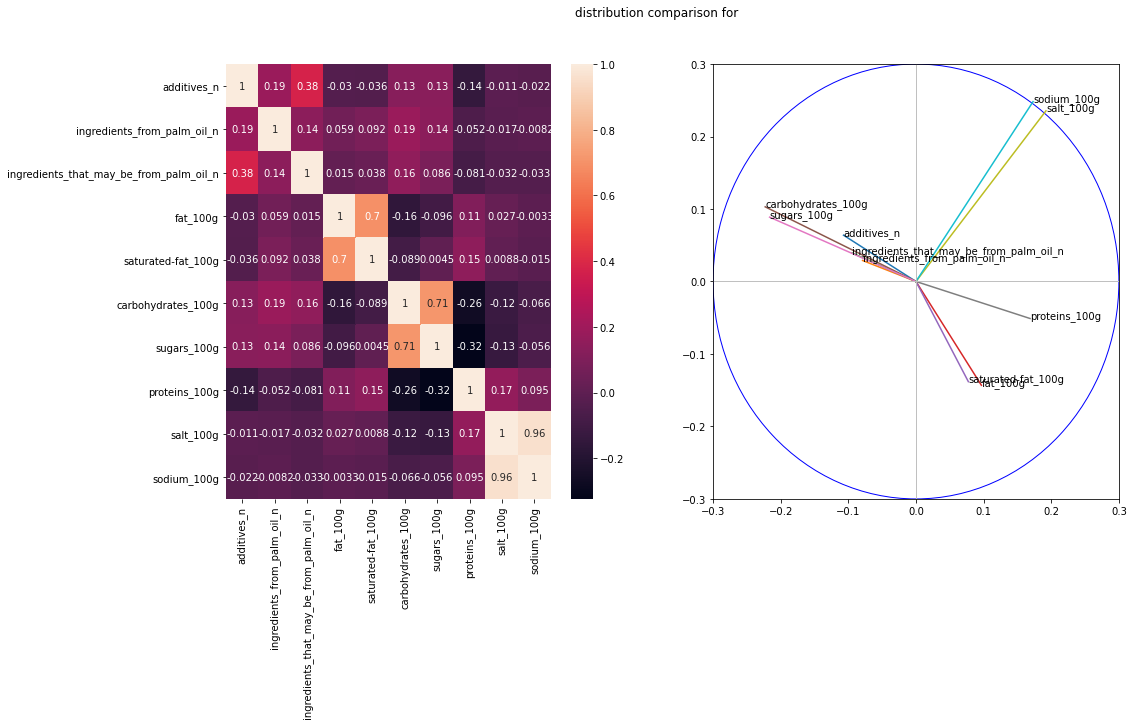

In [80]:
eigval_sqrt = np.sqrt(pca.explained_variance_ratio_)

corvar = np.zeros((len(eigval_sqrt),len(eigval_sqrt)))

for k in range(len(eigval_sqrt)):
    corvar[:,k] = pca.components_[k,:] * eigval_sqrt[k]
print(corvar)

# size_max = corvar.max()
size_max= 0.3

# fig, axes = plt.subplots(figsize=(10,10))
# axes.set_xlim(-1*size_max, size_max)
# axes.set_ylim(-1*size_max, size_max)

# for j in range(len(eigval_sqrt)):
#     plt.annotate(test_sa_don.columns[j],(corvar[j,0],corvar[j,1]))
#     plt.plot([0,corvar[j,0]], [0,corvar[j,1]])
    
# plt.plot([-1*size_max, size_max],[0,0],color='silver',linestyle='-',linewidth=1)
# plt.plot([0,0],[-1*size_max, size_max],color='silver',linestyle='-',linewidth=1)

# cercle = plt.Circle((0,0),size_max,color='blue',fill=False)
# axes.add_artist(cercle)

# plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('distribution comparison for ')

corr = test_sa_don.corr()
sns.heatmap(corr, annot=True, ax=ax1)

ax2.set_xlim(-1*size_max, size_max)
ax2.set_ylim(-1*size_max, size_max)
for j in range(len(eigval_sqrt)):
    ax2.annotate(test_sa_don.columns[j],(corvar[j,0],corvar[j,1]))
    ax2.plot([0,corvar[j,0]], [0,corvar[j,1]])
ax2.plot([-1*size_max, size_max],[0,0],color='silver',linestyle='-',linewidth=1)
ax2.plot([0,0],[-1*size_max, size_max],color='silver',linestyle='-',linewidth=1)

cercle = plt.Circle((0,0),size_max,color='blue',fill=False)
ax2.add_artist(cercle)
plt.show()

#### Remarque: Ce cercle de corrélation vient justifier les corrélations mises en avant précédemment notamment sur:
_fat_100g et saturated-fat_100g<br/>
_carbohydrates_100g et surgars_100g<br/>
_ingredients_that_may_be_from_palm_oil_n et ingredients_from_palm_oil_n<br/>

0


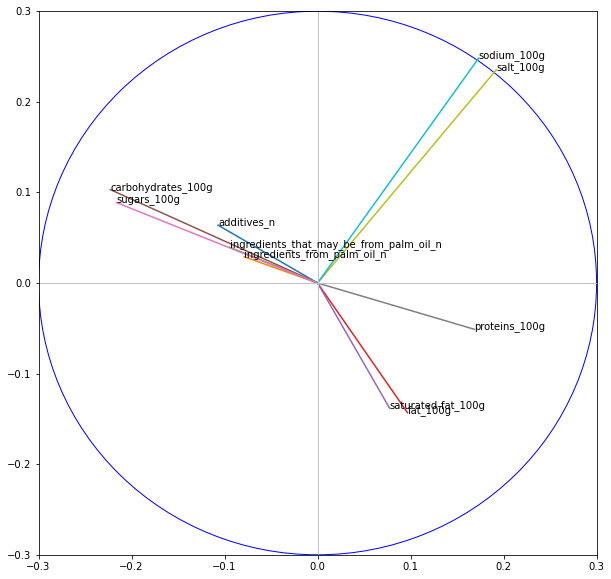

1


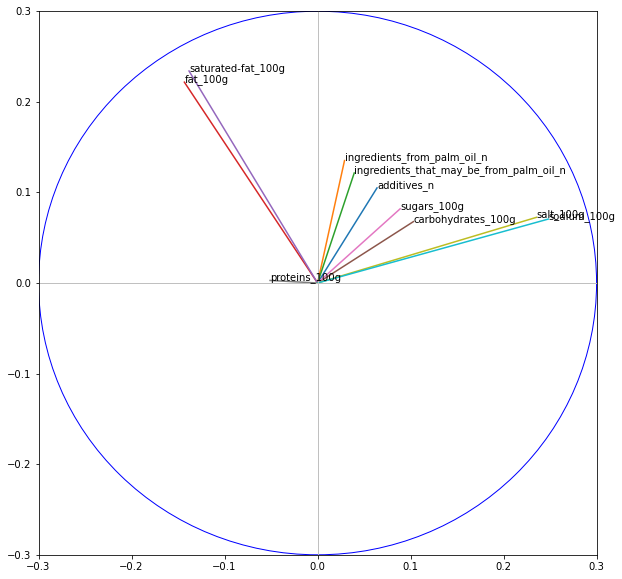

2


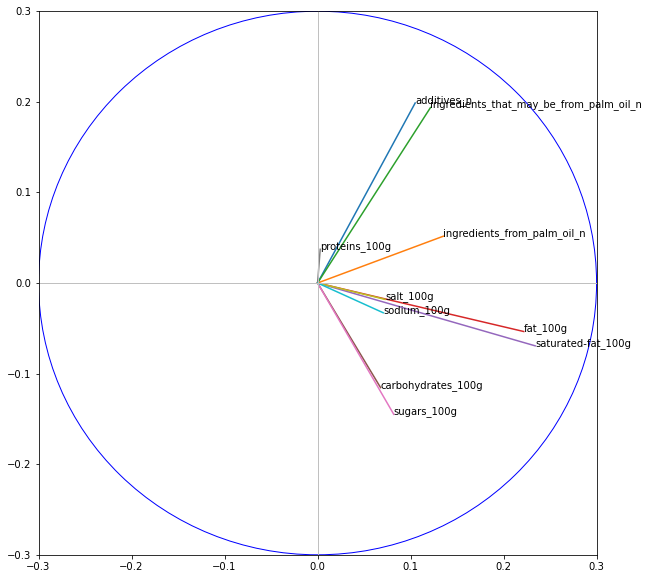

3


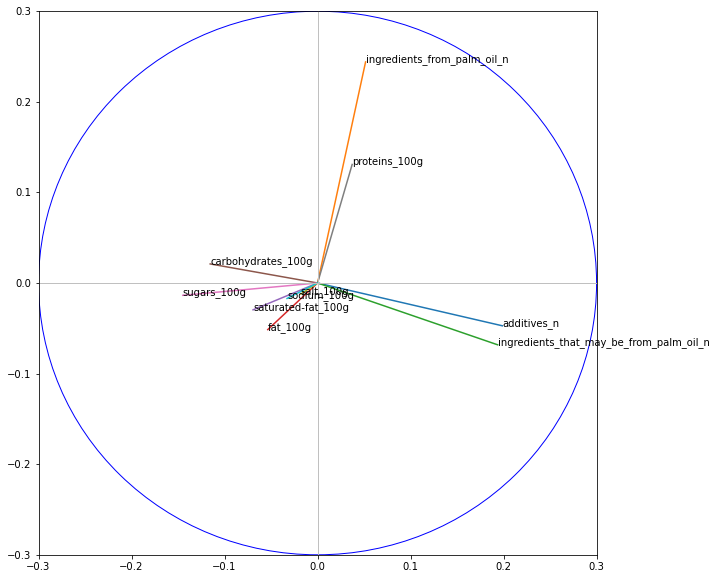

4


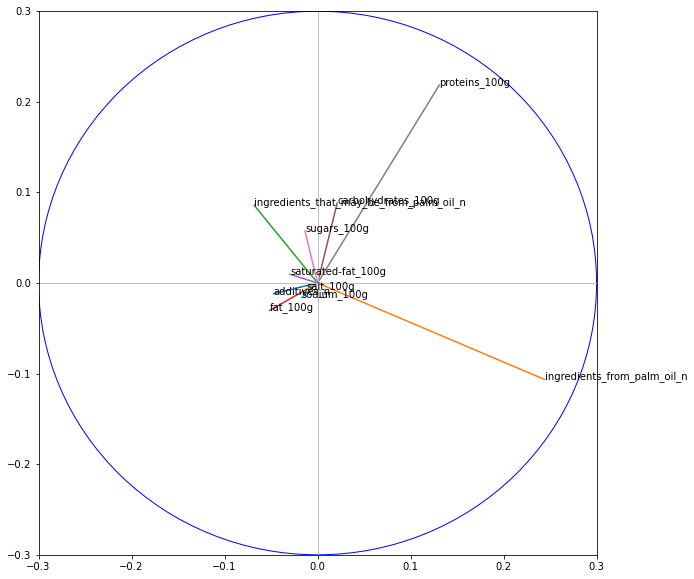

5


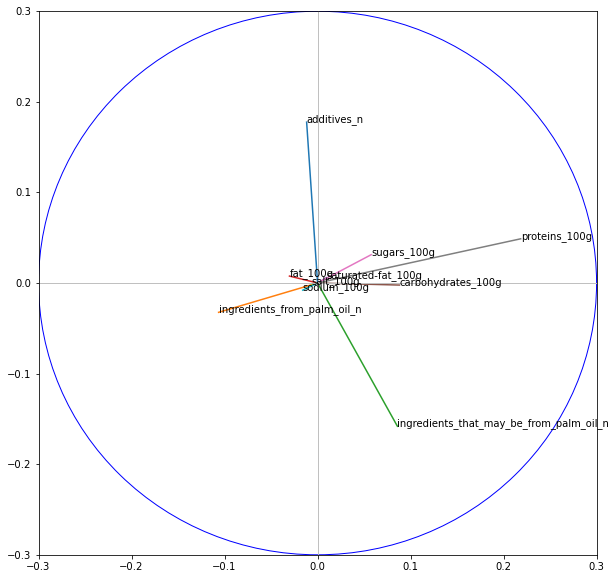

6


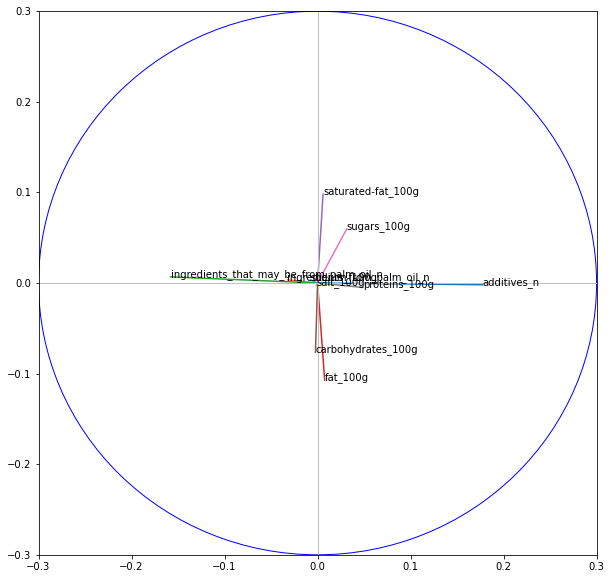

7


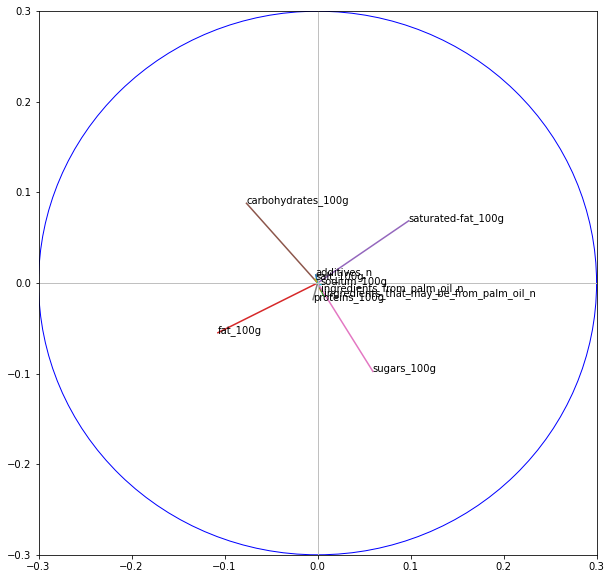

8


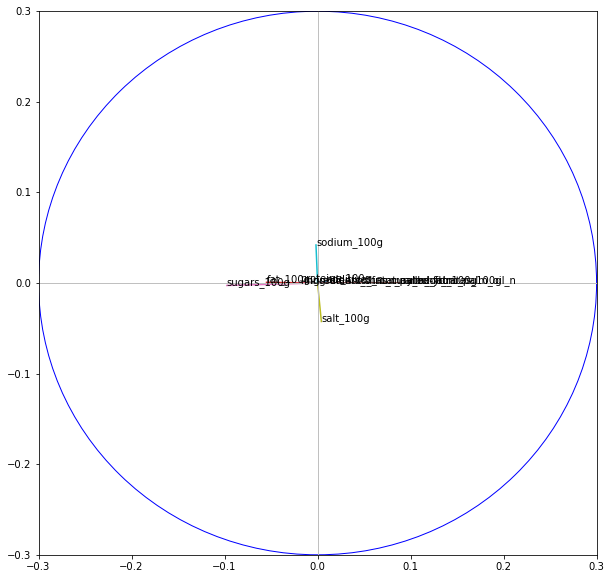

In [80]:
size_max= 0.3
for i in range(len(eigval_sqrt)-1):
    print(i)
    fig, axes = plt.subplots(figsize=(10,10))
    axes.set_xlim(-1*size_max, size_max)
    axes.set_ylim(-1*size_max, size_max)

    for j in range(len(eigval_sqrt)):
        plt.annotate(test_sa_don.columns[j],(corvar[j,i],corvar[j,i+1]))
        plt.plot([0,corvar[j,i]], [0,corvar[j,i+1]])

    plt.plot([-1*size_max, size_max],[0,0],color='silver',linestyle='-',linewidth=1)
    plt.plot([0,0],[-1*size_max, size_max],color='silver',linestyle='-',linewidth=1)

    cercle = plt.Circle((0,0),size_max,color='blue',fill=False)
    axes.add_artist(cercle)

    plt.show()

### Avec le pairplot et le regplot observons les relations précédemment relevées.

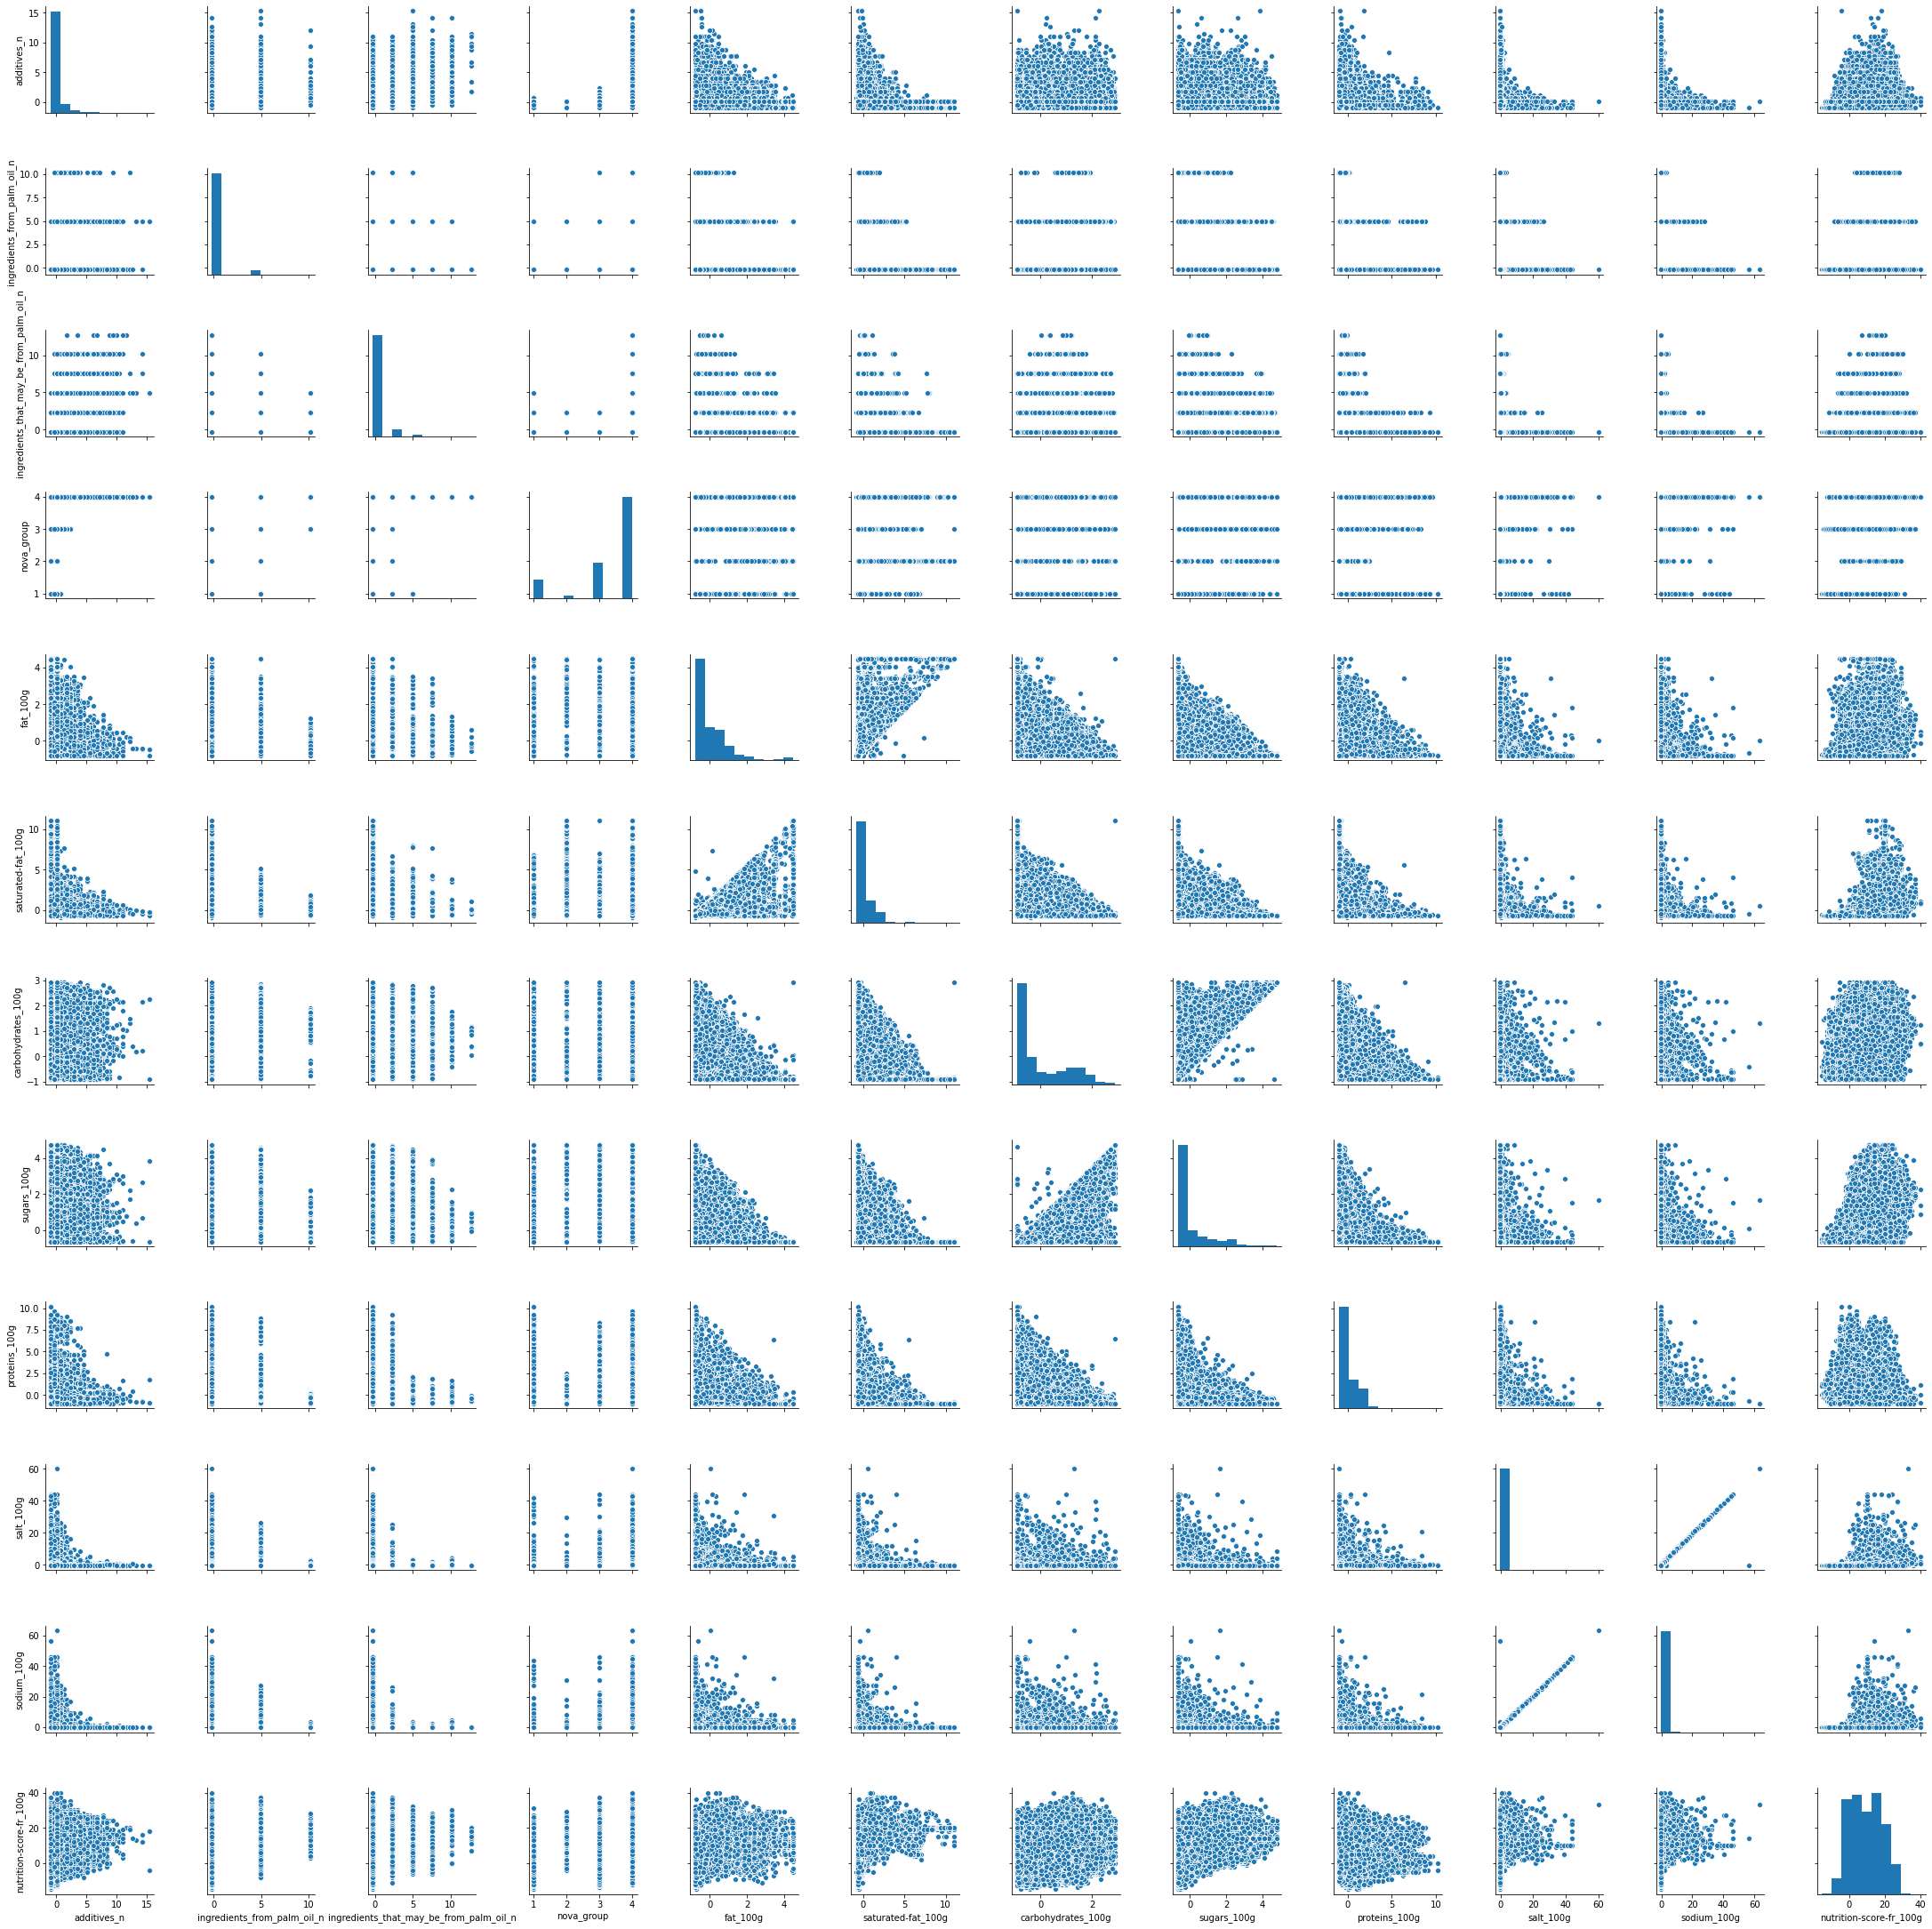

In [66]:
data_pp = data_fr_clean_fill.iloc[3:,:]
data_pp = data_pp.drop(columns=['code', 'product_name', 'ingredients_text','nutriscore_grade', 'main_category'])
sns.pairplot(data_pp)
# data_pp.columns.values

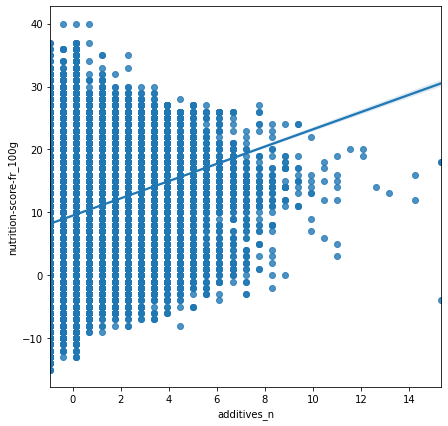

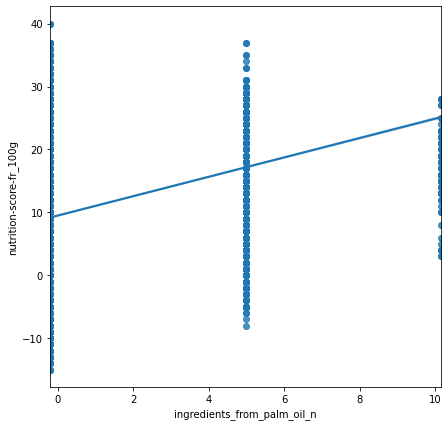

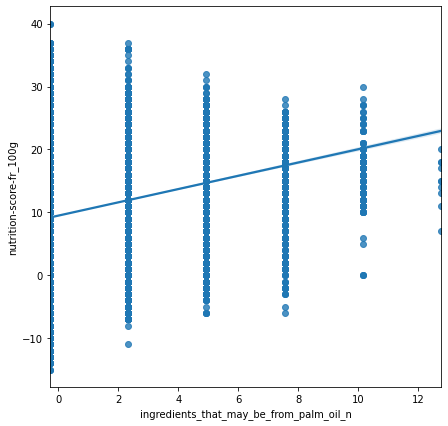

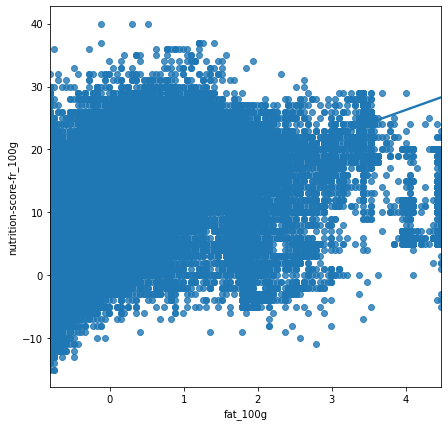

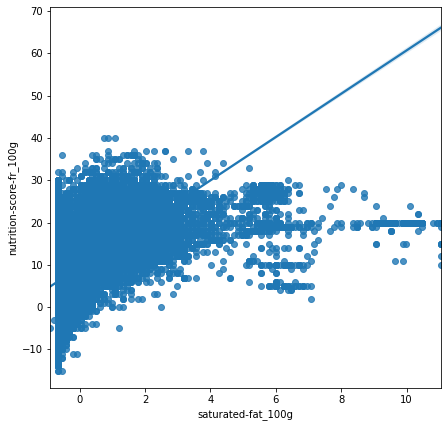

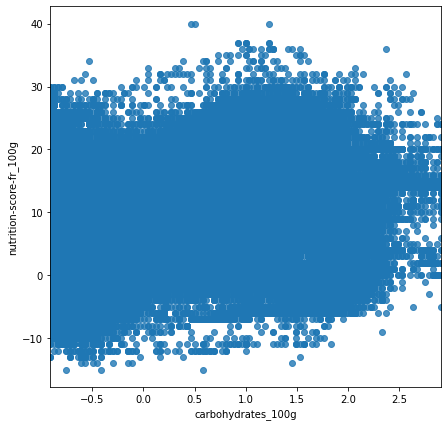

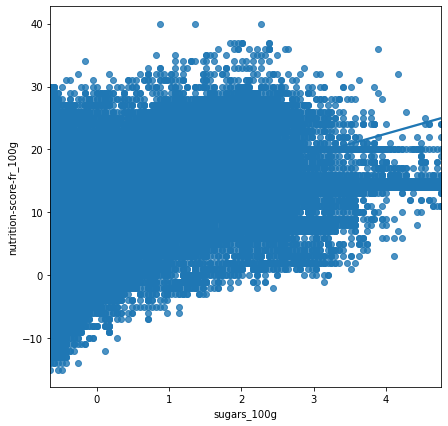

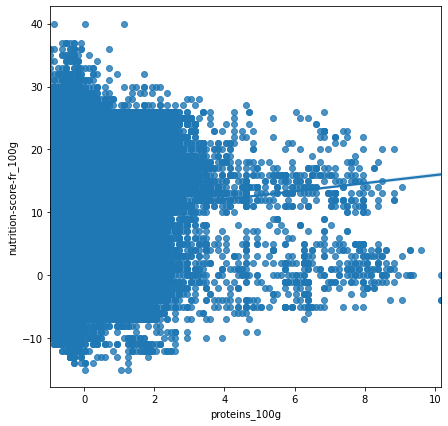

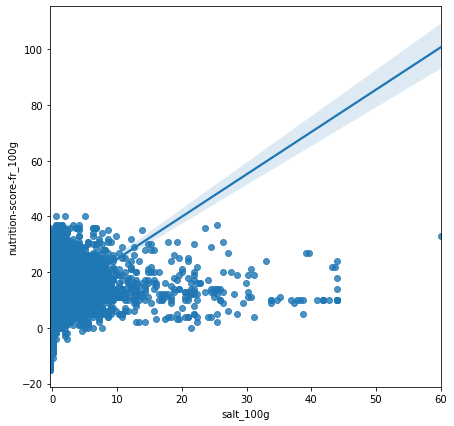

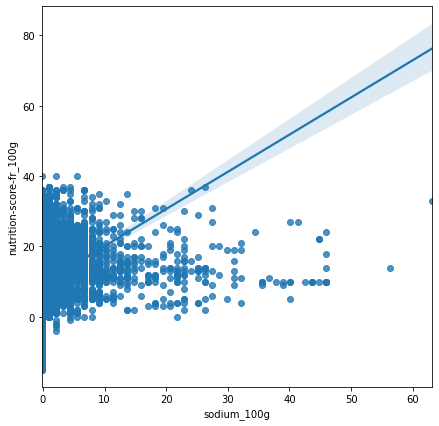

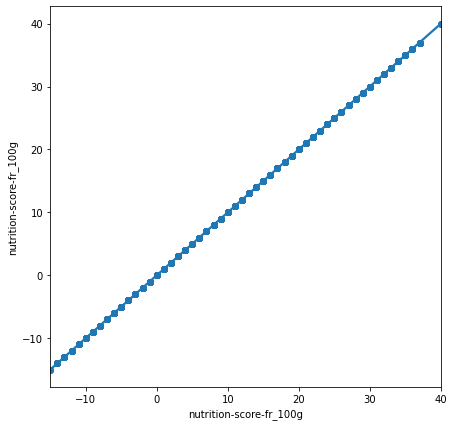

In [29]:
test_sa_don_2 = test_sa_don.copy()
test_sa_don_2["nutrition-score-fr_100g"] = data_fr_clean_fill["nutrition-score-fr_100g"]

for i in test_sa_don.columns:
    plt.figure(figsize=(7,7))
    sns.regplot(x=i,y="nutrition-score-fr_100g",data=test_sa_don_2)

### Ces variables suivent-elles une loi normale?

In [40]:
for i in test_sa_don.columns:
    stats, pval = shapiro(test_sa_don[i])
    print(pval)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


C:\Users\Anwender\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Remarque comme on peut le voir sur les différents graphes précédents et sur les p-value de ces test de normalité(shapiro) sur les variables numériques, aucune d'entre elle ne suit de distribution normale. 

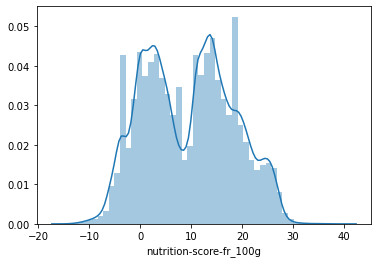

In [44]:
# stats, pval = shapiro(data_fr_clean_fill['nutrition-score-fr_100g'])
# print(pval)
sns.distplot(data_fr_clean_fill['nutrition-score-fr_100g'])

#### Remarque: same goes pour la variable cible nutrition-score-fr_100g, pas de distribution normale car bimodale

## Passons maintenant à un test d'anova entre le nutriscoregrade, qui permettra à terme de prédire le nutriscore, et les différents nutriments du dataset.
Pour cela on passera par un anova suivi d'une comparaison par tukey.

In [97]:
#essai
from statsmodels.stats.multicomp import pairwise_tukeyhsd

test_anova = pd.DataFrame(data=data_fr_clean_fill['additives_n'])
test_anova['qualitat']=data_fr_clean_fill['nova_group']
#nutrition-score-fr_100g
omg = ols('additives_n~C(qualitat)', data=test_anova).fit()
anova = sm.stats.anova_lm(omg, type=2)
print(anova)


tukey = pairwise_tukeyhsd(endog=test_anova['additives_n'],
                          groups=test_anova['qualitat'],
                          alpha=0.05)
print(tukey)

                   df         sum_sq      mean_sq             F  PR(>F)
C(qualitat)       3.0   36587.933279  12195.97776  14605.435602     0.0
Residual     221786.0  185197.976773      0.83503           NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.1563  0.001 -0.199 -0.1137   True
     1      3   0.0221 0.0078 0.0043  0.0399   True
     1      4   0.8513  0.001 0.8356   0.867   True
     2      3   0.1784  0.001 0.1369  0.2199   True
     2      4   1.0076  0.001  0.967  1.0483   True
     3      4   0.8292  0.001  0.817  0.8414   True
---------------------------------------------------


In [96]:
for i in test_sa_don.columns:
    print('\n'+i)
    test_anova = pd.DataFrame(data=data_fr_clean_fill[i])
    test_anova['qualitat']=data_fr_clean_fill['nutriscore_grade']
    test_anova = test_anova.rename(columns={i:'quantitat'})
    
    omg = ols('quantitat~C(qualitat)', data=test_anova).fit()
    anova = sm.stats.anova_lm(omg, type="3")
    print(anova)
    
    tukey = pairwise_tukeyhsd(endog=test_anova['quantitat'],
                          groups=test_anova['qualitat'],
                          alpha=0.05)
    print(tukey)


additives_n
                   df         sum_sq      mean_sq            F  PR(>F)
C(qualitat)       4.0    6191.276964  1547.819241  1592.261762     0.0
Residual     221785.0  215594.633087     0.972088          NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     a      b   0.2736 0.001 0.2514 0.2957   True
     a      c   0.3928 0.001 0.3731 0.4124   True
     a      d   0.4827 0.001 0.4642 0.5012   True
     a      e     0.51 0.001   0.49   0.53   True
     b      c   0.1192 0.001 0.0992 0.1392   True
     b      d   0.2091 0.001 0.1902  0.228   True
     b      e   0.2364 0.001  0.216 0.2568   True
     c      d   0.0899 0.001  0.074 0.1058   True
     c      e   0.1172 0.001 0.0996 0.1348   True
     d      e   0.0273 0.001 0.0109 0.0436   True
-------------------------------------------------

ingredients_from_palm_oil_n
                   df         sum_sq      m

                   df         sum_sq     mean_sq          F  PR(>F)
C(qualitat)       4.0    2972.865491  743.216373  753.39504     0.0
Residual     221785.0  218788.596317    0.986490        NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     a      b   0.0059   0.9 -0.0164 0.0282  False
     a      c   0.0969 0.001  0.0771 0.1167   True
     a      d   0.2658 0.001  0.2471 0.2845   True
     a      e   0.2706 0.001  0.2504 0.2908   True
     b      c    0.091 0.001  0.0708 0.1111   True
     b      d   0.2599 0.001  0.2409 0.2789   True
     b      e   0.2647 0.001  0.2442 0.2852   True
     c      d   0.1689 0.001  0.1529 0.1849   True
     c      e   0.1737 0.001   0.156 0.1914   True
     d      e   0.0048   0.9 -0.0117 0.0212  False
--------------------------------------------------


### La conclusion en observant les relations entre différentes variables nutriment et nutrigrade sur p-adj est qu'ils sont presque tous significatifs et qu'ainsi elles sont toutes utiles afin d'établir la variance entre les différents groupes.

# Proof Of Concept

In [94]:
def POC(i, d):
    k = d[d['main_category']==d.loc[i, 'main_category']]
    k = k[k['code']!=d.loc[i, 'code']]
    k = k.sort_values('nutrition-score-fr_100g', ascending=True)
    
    print(k[['code', 'product_name', 'nutrition-score-fr_100g']].iloc[0:5,:])

test_value = 33
print(data_fr_clean_fill[['main_category']].iloc[test_value,:])
print("")
print(data_fr_clean_fill.loc[test_value,['code', 'product_name', 'nutrition-score-fr_100g']])
POC(test_value, data_fr_clean_fill)

main_category    fr:pates-a-sucre
Name: 33, dtype: object

code                       0000010216477
product_name                Pate a sucre
nutrition-score-fr_100g               17
Name: 33, dtype: object
                 code                   product_name  nutrition-score-fr_100g
135046  3543020140884                   Pate a sucre                     14.0
96213   3278584190258                   Pâte à sucre                     14.0
94185   3274371302002                   Pâte à sucre                     14.0
177132  3760214024502  Pâte à sucre bio extra souple                     15.0
96216   3278584190449                   Pâte à sucre                     16.0


#### C'est une approche assez naïve qui peut être affinée en de nombreux points en suivant, les régimes qu'une personne suit, en fonction du métabolisme qu'elle a ou que d'autres personnes ont et qui lui correspondent (collaborative), ou en fonction des recettes, des prix. On pourrait skycraper les sites de recettes en selectionnant les ingrédients et en fonction des recettes récupérées on pourrait AI into les ingrédients rentrés pour définir la recette probable et affiner encore le résultat. Beaucoup de possibilités, mais au moins on prouve avec ce poc que cela est possible. 
il resterait à améliorer certaines tables néanmoins main_category, ingredients_text